# Capstone Project for  Advance Data Science IBM
## Title: Predicting Brazilian stock market index using other global market indexes – overnight market oscillation 
### Raphael Castro da Costa Ferreira

### The main idea

After Brazilian stock market negotiations are closed, NY stock market is still running, and Asian stock market will operate during all night in Brazil, while is day in Asia. So, there is overnight information from abroad that could help to predict the Brazilian close stock market index for the following day, that have not already started. And previous the opening session in Brazil, models can make such one-step ahead estimation, or even during the day, until it is closed (online data).

* The same structure can be applied to other market indexes and assets, taking advantage of overnight circumstances - information available and fast prediction algorithm.


An OLS Model ( non-deep learning algorithm) and a LSTM Model (deep learning) - following Advanced Data Sience with Capstone instructions -  were built in order to capture such relations from Brazilian sotck Exchange index and its counterparts: USA, Japan, China. An interaste rate (USA short-run) was tested (Monetary Policies movements). But it has shown high volatility, poor correlation with target variable, and models performed better without it 


### The Data

Data is free and can be obtained online through an Yahoo Finance API - so, no special data architature system is required, since it is not a huge amount of data (for high frequency data it might change. However, the business problem is overnight oscillations, so daily data is good start).

All the data is nominal (there is no defaltion process, and currencies movements must be captured by indexes itself)

The dependent variable:
     - ^BVSP = Ibovespa Composite Index (Brazil)

The independent variables chosen are relevant financial markets:
     - ^BVSP = Ibovespa Composite Index (Brazil)
     - ^DJI = Dow Jones Composite Index (USA)
     - 000001.SS = SSE Composite Index  (China)
     - ^N225 = Nikey Composite Index (Japan)
     -'^IRX'= 13 Week USA Treasury Bill


Data were cleared (to obtain only the necessary information and NAs due to holidays were filled in with the last observation) and transformed (logarithmic, lagged, scaled and with difference - this last case is the Part II of this code), and inverse transformation at the end of the process.

### The main findings

Data lose value quickly (Financial Market), long lags (and timesteps) are not important (do not bring better results)

Simpler structures perform better than complex structures (More hidden layers did not outperform simpler structures - MAPE and RMSE metrics)

OLS outperformes LSTM, in level, almost the double of LSTM RSME in the test data set

But, there is a problem with stationarity in LSTM residuals (time seires data)

Studies with series in difference (Part II) were performed and, in this case, the LSTM outperform the OLS (lower RMSE), but estimations do no present the same variance, due to log return of a financial asset remains around zero (market efficience theory - arbitrage price opportunities do not persist)

In [6]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Input
from keras.models import Model
from keras import optimizers
from keras.layers.core import Dense, Activation, Dropout
import random 
from math import sqrt
from datetime import date

%matplotlib inline

## Getting free and online Data

In [7]:
# Data Source: Yahoo Financial API

# give the index that we want to use
tickers = ['^BVSP','^DJI','^N225','000001.SS']#,'^IRX']

# dates: start and the most recent
start_date = '1995-01-01'
today=date.today()
d1 = today.strftime("%Y-%m-%d")
#d1 = today.strftime("%m-%d-%Y")
end_date = d1

# DataReader to load the desired data (google finance it is out of work): Up to date remote data access for pandas 
Fulldata = data.DataReader(tickers, 'yahoo', start_date, end_date)




## Initial Data exploration

In [8]:
# just taking a look into our data
Fulldata.head()

Attributes        High                                                 Low  \
Symbols      000001.SS        ^BVSP         ^DJI         ^N225   000001.SS   
Date                                                                         
1995-01-02  647.859985  4397.600098          NaN           NaN  647.859985   
1995-01-03  639.880005  4385.899902  3845.199951           NaN  639.880005   
1995-01-04  653.809998  4098.000000  3857.989990  19724.759766  653.809998   
1995-01-05  646.890015  4040.300049  3860.679932  19717.759766  646.890015   
1995-01-06  640.760010  4105.700195  3887.260010  19586.490234  640.760010   

Attributes                                                Open               \
Symbols           ^BVSP         ^DJI         ^N225   000001.SS        ^BVSP   
Date                                                                          
1995-01-02  4300.100098          NaN           NaN  647.859985  4353.899902   
1995-01-03  4093.699951  3827.709961           NaN  639.880005  4369.899902   
1995-01-04  3860.899902  3831.070068  19641.220703  653.809998  4098.000000   
1995-01-05  3944.500000  3843.189941  19518.160156  646.890015  3967.899902   
1995-01-06  3813.000000  3841.840088  19417.210938  640.760010  4036.699951   

Attributes  ...        Close                  Volume                          \
Symbols     ...         ^DJI         ^N225 000001.SS ^BVSP        ^DJI ^N225   
Date        ...                                                                
1995-01-02  ...          NaN           NaN       0.0   0.0         NaN   NaN   
1995-01-03  ...  3838.479980           NaN       0.0   0.0  24440000.0   NaN   
1995-01-04  ...  3857.649902  19684.039062       0.0   0.0  27220000.0   0.0   
1995-01-05  ...  3850.919922  19616.109375       0.0   0.0  25810000.0   0.0   
1995-01-06  ...  3867.409912  19519.460938       0.0   0.0  30240000.0   0.0   

Attributes   Adj Close                                          
Symbols      000001.SS        ^BVSP         ^DJI         ^N225  
Date                                                            
1995-01-02  647.859985  4301.000000          NaN           NaN  
1995-01-03  639.880005  4098.000000  3838.479980           NaN  
1995-01-04  653.809998  3967.899902  3857.649902  19684.039062  
1995-01-05  646.890015  4036.699951  3850.919922  19616.109375  
1995-01-06  640.760010  3827.399902  3867.409912  19519.460938  

[5 rows x 24 columns]

###  Data cleansing 

In [9]:
#We need to get only the closing prices (e.g. indexes) for each market
df = Fulldata['Close']
df.head()

Symbols,000001.SS,^BVSP,^DJI,^N225
Date,,,,
1995-01-02,647.859985,4301.000000,NaN,NaN
1995-01-03,639.880005,4098.000000,3838.479980,NaN
1995-01-04,653.809998,3967.899902,3857.649902,19684.039062
1995-01-05,646.890015,4036.699951,3850.919922,19616.109375
1995-01-06,640.760010,3827.399902,3867.409912,19519.460938


In [10]:
df.tail()

Symbols,000001.SS,^BVSP,^DJI,^N225
Date,,,,
2019-10-03,NaN,101516.00000,26201.039062,21341.740234
2019-10-04,NaN,102551.00000,26573.720703,21410.199219
2019-10-07,NaN,100573.00000,26478.019531,21375.250000
2019-10-08,2913.570068,99981.00000,26164.039062,21587.779297
2019-10-09,2924.856689,101248.78125,26346.009766,21456.380859


In [11]:
#Creating a fixed frequency DatetimeIndex for our dataframe
#Getting all weekdays between the start_data and end_data, and B stands for "business day frequency",
#days where financial market was operating
BusinessWeekdays = pd.date_range(start=start_date, end=end_date, freq='B')

#reindex df using Businessweekdays as the new index
df = df.reindex(BusinessWeekdays)

#Reindexing will insert missing values (NaN) for the dates that were not present
#in the original set. Moreover, there are holidays on different days in these countries. 
#Replacing them with the latest close is what we need to do, 
#as financial market works like that (it remains the latest price when there was no deals)
df = df.fillna(method='ffill')
df=df.dropna(how='any')## if it starts with NaN, since start_daate  could be and there is nothing before that
df.index.names = ['Date']#rename index
df = df[['^BVSP','000001.SS',  '^DJI', '^N225',]]# '^IRX']]# just make sure your target/explained variable is the first one

# since Treasury Bill is a rate, we need to transform this data deviding by 100 and adding 1
#df['^IRX']=df['^IRX']/100+1
df.head(5)
df.tail()

Symbols,^BVSP,000001.SS,^DJI,^N225
Date,,,,
2019-10-03,101516.00000,2905.189941,26201.039062,21341.740234
2019-10-04,102551.00000,2905.189941,26573.720703,21410.199219
2019-10-07,100573.00000,2905.189941,26478.019531,21375.250000
2019-10-08,99981.00000,2913.570068,26164.039062,21587.779297
2019-10-09,101248.78125,2924.856689,26346.009766,21456.380859


### Data Visualization


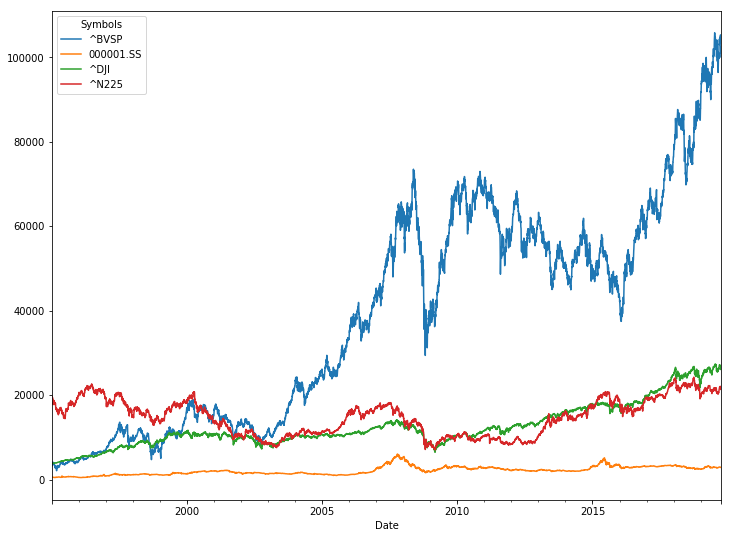

In [12]:
# first inpection: our variables have diffrente levels...
df.plot(figsize=(12,9))
dfo=df #saving the original DataFrame

#### Data Transformation

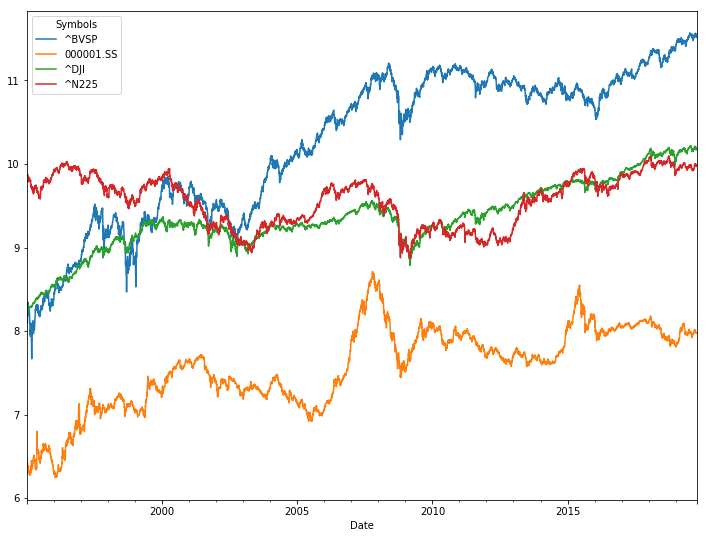

In [13]:
# graph of variables in log: let'us put in log.
# we just can see some comovements 
df =np.log(df)
df=df.dropna(how='any')
dfg=df
dfg.plot(figsize=(12,9))

In [14]:

df.head()

Symbols,^BVSP,000001.SS,^DJI,^N225
Date,,,,
1995-01-04,8.285992,6.482817,8.257813,9.887563
1995-01-05,8.303183,6.472176,8.256067,9.884106
1995-01-06,8.249941,6.462655,8.260340,9.879167
1995-01-09,8.196382,6.439350,8.258772,9.875341
1995-01-10,8.092545,6.413951,8.260167,9.878244


In [16]:
#Descriptive Satistics:
# financial data is very volatile 
df.describe()

Symbols,^BVSP,000001.SS,^DJI,^N225
count,6461.000000,6461.000000,6461.000000,6461.000000
mean,10.252896,7.569805,9.356093,9.563569
std,0.899614,0.489136,0.407885,0.301402
min,7.667766,6.246998,8.251163,8.861489
25%,9.474165,7.233050,9.141320,9.286304
50%,10.622497,7.633234,9.297814,9.632786
75%,10.992403,7.971866,9.632212,9.804153
max,11.569466,8.714741,10.216807,10.097022


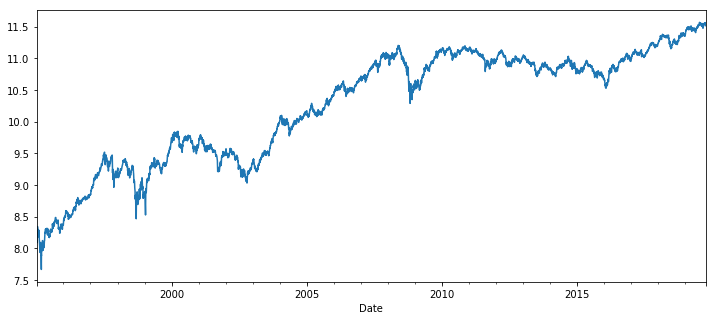

In [11]:
# let'us take a look closely into our target/dependent variable: Brazilian Sotck Exchange Index
# osciliation through time
df['^BVSP'].plot(figsize=(12,5))

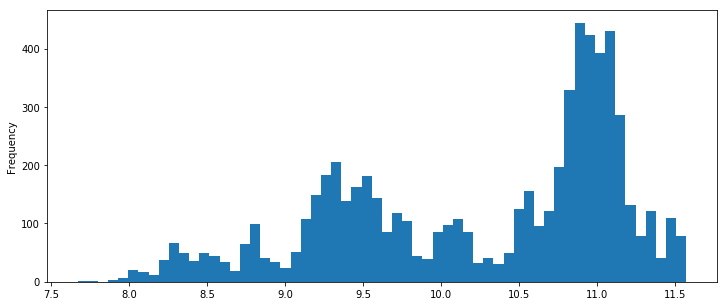

In [18]:
#our target variable histogram: it has 2 peaks of concetration (9.4 and 11), and different from a normal distribution
# This is very different when difference is taken (appendix)
df['^BVSP'].plot.hist(bins = 60,figsize=(12,5))

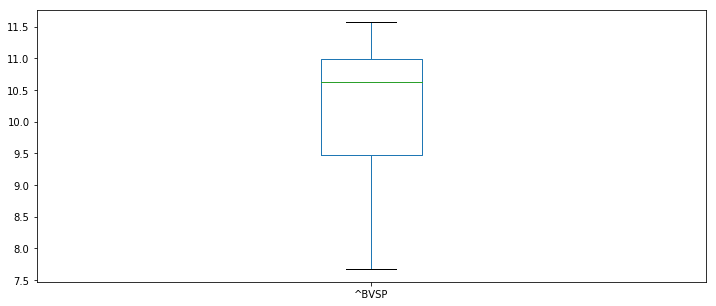

In [21]:
df['^BVSP'].plot.box(figsize=(12,5))

In [22]:
#Correlation matrix: comovements
# USA/DJI has the biggest correlation with BRA/BVSP. Shanghai also presentes a good correlation with BVSP.
# As mentioned early, ^IRX (USA treasury bill was dropped: low correlation, to much volatility )
df.corr()

Symbols,^BVSP,000001.SS,^DJI,^N225
Symbols,,,,
^BVSP,1.000000,0.857977,0.830463,-0.053551
000001.SS,0.857977,1.000000,0.774681,-0.016857
^DJI,0.830463,0.774681,1.000000,0.280915
^N225,-0.053551,-0.016857,0.280915,1.000000


## Models

### Data Preparation: transformation

In [24]:
# defining the batch size and number of epochs for stateful LSTM
# Several combination were tested
batch_size = 180# 64, 32, 16, 8 
timesteps = 10
test_percent=.05 #.2, 0.1
print(len(df))

6461


In [25]:
## Scaling data 
dataset = df
values = dataset.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_features = df.shape[1]

In [26]:
## function in order to create our variables lags
###https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [27]:
##  MAPE: evaluation metric
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
reframed = series_to_supervised(scaled, timesteps,1)                                                          
reframed.shape

(6451, 44)

In [30]:
# getting the train and test dataset size for a Stateful Model (LSTM)

def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            #print(x)
    return (max(train_length_values))

length = get_train_length(reframed, batch_size, test_percent)
upper_train = length + timesteps*2
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            #print(x)
    return (max(test_length_values))


test_length = get_test_length(reframed, batch_size)


print(length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)




6120
180


In [31]:
# split into train and test sets
values = reframed.values
## must starts from the end to the begin (though not all data from the begging will be used, due to batch_size)
train = values[len(reframed)-length-testset_length:-testset_length,:]
test = values[-testset_length:]

# split into input and outputs
n_obs = timesteps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(6120, 40) 6120 (6120,)


### OLS Model

In [32]:
import statsmodels.api as sm

trainyols=train_y 
testyols=test_y

train_Xols= sm.add_constant(train_X)
test_Xols=sm.add_constant(test_X)
modelos = sm.OLS(trainyols,train_Xols)


results = modelos.fit()
par=results.params
#results.summary()

In [33]:
yhattrainols=results.predict(train_Xols)
yhatols=results.predict(test_Xols)

#### MAPE and RMSE for evaluation

In [34]:
# MAPE and RMSE for evaluation
mapetrainOls = mean_absolute_percentage_error(trainyols, yhattrainols)
mapetestOls = mean_absolute_percentage_error(testyols, yhatols) 


rmsetrainOls = sqrt(mean_squared_error(trainyols, yhattrainols))
rmsetestOls = sqrt(mean_squared_error(testyols, yhatols ))

print('\033[1m' +'MAPE Train:' + '\033[0m',"%.4f"%mapetrainOls)
print('\033[1m' +'MAPE Test:' + '\033[0m',"%.4f"%mapetestOls)
print('\033[1m' +'RMSE Train:' + '\033[0m',"%.4f"%rmsetrainOls)
print('\033[1m' +'RMSE Test:' + '\033[0m',"%.4f"%rmsetestOls)

MAPE Train: 0.6429
MAPE Test: 0.2399
RMSE Train: 0.0050
RMSE Test: 0.0031


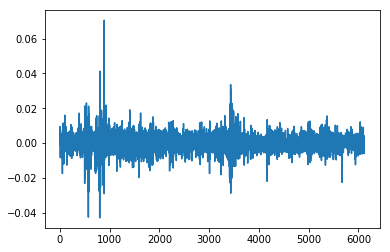

In [36]:
#residuals graph
# close to zero. Evidence that residuals are stationary (variables might cointegrate) and stable
r=results.resid
plt.plot(r)

In [37]:
## Augmented Dick-Fuller test in order to check if resids are stationary: evidence of cointegration
from statsmodels.tsa.stattools import adfuller

result = adfuller(r)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.414333
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


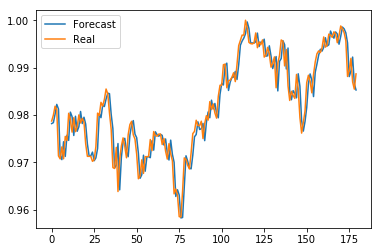

In [38]:
#graph: OLS Forecast and Real data
plt.plot(yhatols[-1000:],label='Forecast')
plt.plot(testyols[-1000:],label='Real')
plt.legend()
plt.show()

In [39]:
# invert scaling for forecast
test_Xd = test_Xols.reshape((test_Xols.shape[0], test_Xols.shape[1]))
yhatols=pd.DataFrame(yhatols)
inv_yhatols = np.concatenate((yhatols, test_Xd[:, -(len(df.columns)-1):]), axis=1)
inv_yhatols = scaler.inverse_transform(inv_yhatols)
inv_yhatols = inv_yhatols[:,0]
nyhatols=pd.Series(np.exp(inv_yhatols))

In [40]:
print('Prediction call OLS for today',"%.2f"%nyhatols.iloc[[-1]])

Prediction call OLS for today 99914.40


### LSTM Model

In [42]:
# Another Data prepartion
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], timesteps, n_features))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


#### Hyperparameters tested and selected

In [43]:
## Hyperparamters tests: remaining only the best combination
batch_size = 180#  64, 32, 16, 8 
epochs =600#[160,250,400,600,1000]
ltest_percent=.05
listan=[44]#[30,55,44,100] 
listafuncao=['linear']   #[linear''relu','elu']
listalraprend = [0.01]#,0.01]
listaotm = ['adam'] #['adam']
listadrop=[0.3] #[0.2,0.3,0.4]
listafuncaop=['mse'] #['mae','mse']
tam=len(listan)*len(listafuncao)*len(listalraprend)*len(listaotm)*len(listadrop)*len(listafuncaop)
print(tam)

1


#### Sequence of for's and keeping results

In [44]:
#Modeling: for's in order to get results from hyperparameters combinations
resultadosn=[]
resultadosfuncaoact=[]
resultadoslraprend=[]
resultadosotm=[]
resultadosdrop=[]
resultadosfp=[]
resultadosmapetrain=[]
resultadosmapetest=[]
resultadosrmsetrain=[]
resultadosrmsetest=[]
dfresultados_ypredtrain= pd.DataFrame(np.zeros((length,tam)))
dfresultados_ypredtest= pd.DataFrame(np.zeros((testset_length,tam)))
i=0
for n1 in listan:
    for funcaoact in listafuncao:
        for lraprend in listalraprend:
            for otm in listaotm:
                for drop in listadrop:
                    for fp in listafuncaop:
                                np.random.seed(123)
                                
                                ## Scaling data for LSTM
                                dataset = df
                                values = dataset.values
                                values = values.astype('float32')
                                scaler = MinMaxScaler(feature_range=(0, 1))
                                scaled = scaler.fit_transform(values)
                                n_features = df.shape[1]
                                
                                
                                # getting the train and test dataset size
                                length = get_train_length(reframed, batch_size, test_percent)
                                upper_train = length + timesteps*2
                                test_length = get_test_length(reframed, batch_size)
                                upper_test = test_length + timesteps*2
                                testset_length = test_length - upper_train
                                # split into train and test sets
                                values = reframed.values
                                ## must starts from the end to the begin (though not all data from the begging will be used, due to batch_size)
                                train = values[len(reframed)-length-testset_length:-testset_length,:]
                                test = values[-testset_length:]
                                
                                # split into input and outputs
                                n_obs = timesteps * n_features
                                train_X, train_y = train[:, :n_obs], train[:, -n_features]
                                test_X, test_y = test[:, :n_obs], test[:, -n_features]
                                #print(train_X.shape, len(train_X), train_y.shape)
                                
                                # reshape input to be 3D [samples, timesteps, features]
                                train_X = train_X.reshape((train_X.shape[0], timesteps, n_features))
                                test_X = test_X.reshape((test_X.shape[0], timesteps, n_features))
                                
                                
                                ## Stateful 1 layer
                                model1 = Sequential()
                                model1.add(LSTM(n1, batch_input_shape=(batch_size,timesteps,train_X.shape[2]),stateful=True))
                                model1.add(Activation(funcaoact))
                                model1.add(Dropout(drop))
                                model1.add(Dense(1))
                                sgd = optimizers.SGD(lr=lraprend, momentum=0.9, nesterov=True)
                                adam = optimizers.adam(lr=lraprend)
                                rmsprop = optimizers.RMSprop(lr=lraprend)
                                model1.compile(loss = fp, optimizer = otm)
                                # fit network
                                history = model1.fit( train_X ,train_y ,validation_data = (test_X, test_y)
                                                         ,epochs = epochs 
                                                         ,batch_size = batch_size
                                                         ,verbose = 0
                                                         ,shuffle = False)# plot history
                                model1.reset_states()
                                
                                
                                #Predict
                                yhattrain1 = model1.predict(train_X,batch_size=batch_size,verbose=0)
                                yhat1 = model1.predict(test_X,batch_size=batch_size,verbose=0)
                                
                                
                                #Avaliacao
                                
                                mapetrain = mean_absolute_percentage_error(train_y[-4000:],yhattrain1[-4000:])
                                mapetest = mean_absolute_percentage_error(test_y, yhat1 )
                                rmsetrain = sqrt(mean_squared_error(train_y, yhattrain1))
                                rmsetest = sqrt(mean_squared_error(test_y, yhat1 ))
                                
 

                                #Guardando resultados
                                resultadosn.append(n1)
                                resultadosfuncaoact.append(funcaoact)
                                resultadoslraprend.append(lraprend)
                                resultadosotm.append(otm)
                                resultadosdrop.append(drop)
                                resultadosfp.append(fp)
                                resultadosmapetrain.append(mapetrain)
                                resultadosmapetest.append(mapetest)
                                resultadosrmsetrain.append(rmsetrain)
                                resultadosrmsetest.append(rmsetest)                    
                                dfresultados_ypredtrain.iloc[:,i]=yhattrain1
                                dfresultados_ypredtest.iloc[:,i]=yhat1
                                i+=1

                                print("%s, %s, %s, %s, %s,%s, %.2f, %.2f, %.2f, %.2f   " % (n1, funcaoact, otm, lraprend,drop,fp,mapetrain,mapetest,rmsetrain,rmsetest))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
44, linear, adam, 0.01, 0.3,mse, 12.69, 3.23, 0.01, 0.03   


In [45]:
#Keeping results and getting the lowest MAPE in test data set
dfresultados = pd.concat([pd.DataFrame(resultadosn,columns=['# of Neurons ']),pd.DataFrame(resultadosfuncaoact,columns=['Activation Function']),pd.DataFrame(resultadoslraprend,columns=['Learning Rate']),pd.DataFrame(resultadosotm,columns=['Otmzador']),pd.DataFrame(resultadosdrop,columns=['Drop']),pd.DataFrame(resultadosfp,columns=['Loss Function']),pd.DataFrame(resultadosmapetrain,columns=['MAPE Train']),pd.DataFrame(resultadosmapetest,columns=['MAPE Test']),pd.DataFrame(resultadosrmsetrain,columns=['RMSE Train']),pd.DataFrame(resultadosrmsetest,columns=['RMSE Test'])],axis=1)
index_melhorserie=dfresultados.index[dfresultados['MAPE Test']==dfresultados['MAPE Test'].min()].tolist()
print(index_melhorserie)

[0]


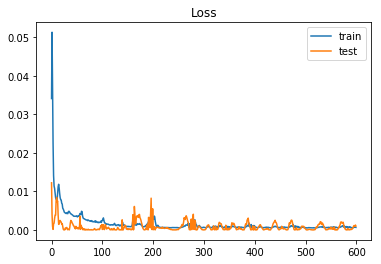

In [46]:
# plot loss during training

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

#### MAPE and RMSE for evaluation

In [47]:
print(dfresultados.loc[index_melhorserie])
print('\033[1m' +'Best MAPE Train:' + '\033[0m',"%.4f"%dfresultados.loc[index_melhorserie, 'MAPE Train'])
print('\033[1m' +'Best MAPE Test:' + '\033[0m',"%.4f"%dfresultados.loc[index_melhorserie, 'MAPE Test'])
print('\033[1m' +'Best RMSE Train:' + '\033[0m',"%.4f"%dfresultados.loc[index_melhorserie, 'RMSE Train'])
print('\033[1m' +'Best RMSE Test:' + '\033[0m',"%.4f"%dfresultados.loc[index_melhorserie, 'RMSE Test'])


   # of Neurons  Activation Function  Learning Rate Otmzador  Drop  \
0             44              linear           0.01     adam   0.3   

  Loss Function  MAPE Train  MAPE Test  RMSE Train  RMSE Test  
0           mse   12.694834   3.232677    0.012936   0.032059  
Best MAPE Train: 12.6948
Best MAPE Test: 3.2327
Best RMSE Train: 0.0129
Best RMSE Test: 0.0321


In [48]:
# saveing the model 

import h5py
model1.save(filepath="lstm_stockindex_model.h5")
from keras.models import load_model
model1 = load_model(filepath="lstm_stockindex_model.h5")

yhattrain1 = model1.predict(train_X,batch_size=batch_size,verbose=0)
yhat1 = model1.predict(test_X,batch_size=batch_size,verbose=0)

In [50]:
# getting the best model predictions (when have several models from hyperparameters combinations)
index_melhorserie=dfresultados.index[dfresultados['MAPE Test']==dfresultados['MAPE Test'].min()].tolist()
yhattrain1=dfresultados_ypredtrain.iloc[:,index_melhorserie]
yhat1=dfresultados_ypredtest.iloc[:,index_melhorserie]

trainy= pd.Series(train_y)
testy=pd.Series(test_y)

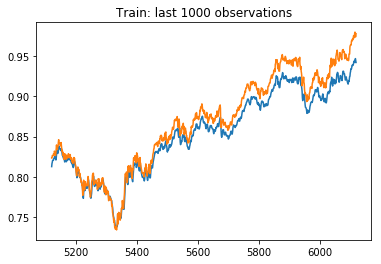

In [51]:
# trainning plot
plt.title('Train: last 1000 observations')
plt.plot(yhattrain1[-1000:])
plt.plot(trainy[-1000:])

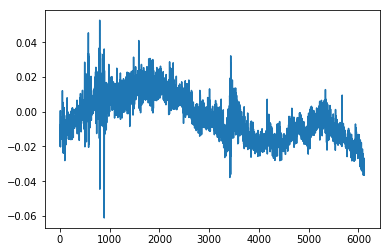

In [52]:
## Residuals graph
res=(yhattrain1[0]-trainy)
plt.plot(res)

In [53]:
## Augmented Dick-Fuller test in order to check if resids are stationary
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.025743
p-value: 0.743760
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


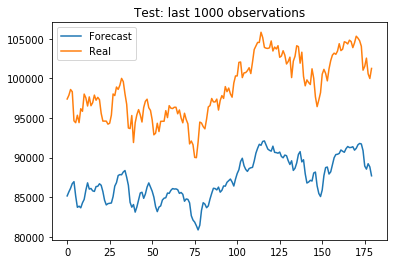

In [54]:
### Invert Scaling for test dataset
test_X1 = test_X.reshape((test_X.shape[0], timesteps*n_features))
# invert scaling for forecast
inv_yhat1 = np.concatenate((yhat1, test_X1[:, -(len(df.columns)-1):]), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]
nyhat1=np.exp(inv_yhat1)

# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y1 = np.concatenate((test_y1, test_X1[:, -(len(df.columns)-1):]), axis=1)
inv_y1 = scaler.inverse_transform(inv_y1)
inv_y1 = inv_y1[:,0]
nytest1=np.exp(inv_y1)

#test plot
plt.title('Test: last 1000 observations')
plt.plot(nyhat1[-1000:],label='Forecast')
plt.plot(nytest1[-1000:],label='Real')
plt.legend()
plt.show()

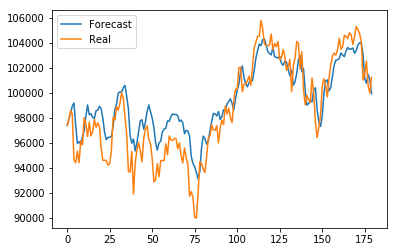

In [55]:
## Appropriate level: oscillations are similar, but level is not
de=pd.Series(nyhat1)- pd.Series(nyhat1).shift(1)
x=(nytest1[0])
x_diff=de.iloc[1:,]
d=pd.Series(np.r_[x, x_diff].cumsum())

plt.plot(d[-1000:],label='Forecast')
plt.plot(nytest1[-1000:],label='Real')
plt.legend()
plt.show()

In [56]:
print('Prediction call for today',"%.2f"%d.iloc[-1:])

Prediction call for today 99933.65


In [57]:
## Boundaries from RSME
band=(sum((nytest1-d)**2)**0.5)/len(nytest1)
band
print('Prediction - 2.5 deviation',"%.2f"%(d.iloc[-1:]-2.5*band))
print('Prediction + 2.5 deviation',"%.2f"%(dfo.iloc[-1,0:1]+2.5*band))
b1=d+2.5*band
b2=d-2.5*band



Prediction - 2.5 deviation 99605.95
Prediction + 2.5 deviation 101576.47


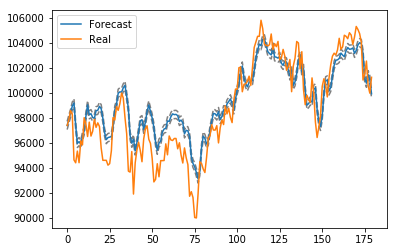

In [58]:
plt.plot(b1,linestyle='--',color='grey')
plt.plot(b2,linestyle='--',color='grey')
plt.plot(d[-1000:],label='Forecast')
plt.plot(nytest1[-1000:],label='Real')
plt.legend()
plt.show()

#### Final Comparison in test data set

In [59]:
## LSTM RMSE
devlstm=(sum((nytest1-d)**2)**0.5)/len(nytest1)
devlstm

131.07673152164594

In [60]:
## OLS RMSE
devlols=(sum((pd.Series(nytest1)-yhatols)**2)**0.5)/len(nytest1)
devlols

0.7051398600435393

In [61]:
print('Prediction OLS call  for today',"%.2f"%nyhatols.iloc[[-1]])
print('Prediction LSTM call for today',"%.2f"%d.iloc[-1:])
print('Actual-Online',"%.2f"%dfo.iloc[-1,0:1])

Prediction OLS call  for today 99914.40
Prediction LSTM call for today 99933.65
Actual-Online 101248.78


# Part II
## Models in Difference





### Data Transformation

In [62]:
# Taking the difference (log difference)
df=df -df.shift(1)
df=df.dropna(how='any')
df.head()

Symbols,^BVSP,000001.SS,^DJI,^N225
Date,,,,
1995-01-05,0.017191,-0.010640,-0.001746,-0.003457
1995-01-06,-0.053242,-0.009521,0.004273,-0.004939
1995-01-09,-0.053559,-0.023305,-0.001568,-0.003826
1995-01-10,-0.103836,-0.025400,0.001395,0.002903
1995-01-11,0.067716,0.004626,-0.001219,0.002408


### Visualization

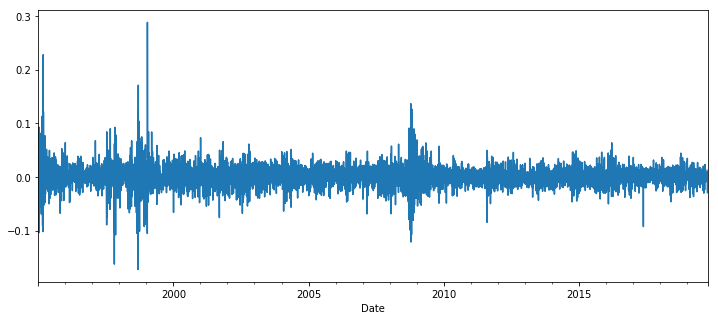

In [63]:
# let'us take a look closely into our target/dependent variable: Brazilian Sotck Exchange Index in difference
# oscillation through time is around zero (Market efficiency theory: arbitrage opportunities tend to zero )
df['^BVSP'].plot(figsize=(12,5))

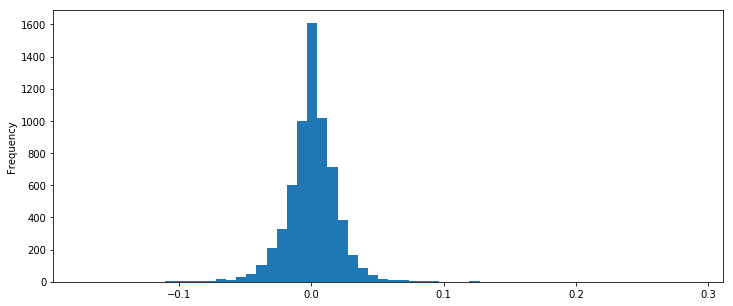

In [64]:
#our target variable histogram: much of the data is around zero, as expected (Market efficiency theory)
df['^BVSP'].plot.hist(bins = 60,figsize=(12,5))

### Data Preparation

In [65]:
# defining the batch size and number of epochs
batch_size = 180# 64, 32, 16, 8 
timesteps = 10
test_percent=.05 #.2, 0.1
print(len(df))

6460


In [66]:
## Scaling data for LSTM
dataset = df
values = dataset.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_features = df.shape[1]

reframed = series_to_supervised(scaled, timesteps,1)                                                          
reframed.shape
length = get_train_length(reframed, batch_size, test_percent)
upper_train = length + timesteps*2
test_length = get_test_length(reframed, batch_size)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train

# split into train and test sets
values = reframed.values
## must starts from the end to the begin (though not all data from the begging will be used, due to batch_size)
train = values[len(reframed)-length-testset_length:-testset_length,:]
test = values[-testset_length:]

# split into input and outputs
n_obs = timesteps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
#print(train_X.shape, len(train_X), train_y.shape)

## OLS Model

In [67]:
import statsmodels.api as sm

trainyols=train_y 
testyols=test_y

train_Xols= sm.add_constant(train_X)
test_Xols=sm.add_constant(test_X)
modelos = sm.OLS(trainyols,train_Xols)


results = modelos.fit()
par=results.params
#results.summary()

In [68]:
yhattrainols=results.predict(train_Xols)
yhatols=results.predict(test_Xols)
mapetrainOls = mean_absolute_percentage_error(trainyols[-4000], yhattrainols[-4000])
mapetestOls = mean_absolute_percentage_error(testyols, yhatols) 


rmsetrainOls = sqrt(mean_squared_error(trainyols, yhattrainols))
rmsetestOls = sqrt(mean_squared_error(testyols, yhatols ))

print('\033[1m' +'MAPE Train:' + '\033[0m',"%.4f"%mapetrainOls)
print('\033[1m' +'MAPE Test:' + '\033[0m',"%.4f"%mapetestOls)
print('\033[1m' +'RMSE Train:' + '\033[0m',"%.4f"%rmsetrainOls)
print('\033[1m' +'RMSE Test:' + '\033[0m',"%.4f"%rmsetestOls)

MAPE Train: 6.9265
MAPE Test: 5.4762
RMSE Train: 0.0420
RMSE Test: 0.0262


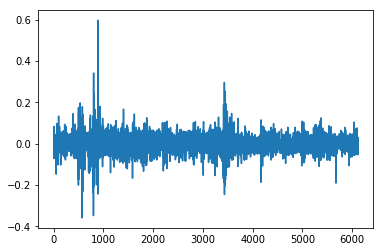

In [69]:
r=results.resid
plt.plot(r)

In [70]:
## Augmented Dick-Fuller test in order to check if resids are statonary: evidence of cointegration
from statsmodels.tsa.stattools import adfuller

result = adfuller(r)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -78.308710
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


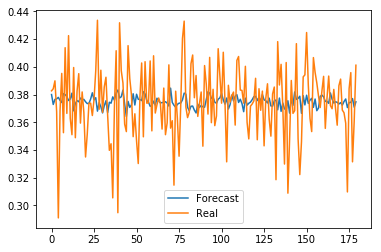

In [71]:
plt.plot(yhatols[-1000:],label='Forecast')
plt.plot(testyols[-1000:],label='Real')
plt.legend()
plt.show()

In [72]:
# invert scaling for forecast
test_Xd = test_Xols.reshape((test_Xols.shape[0], test_Xols.shape[1]))
yhatols=pd.DataFrame(yhatols)
inv_yhatols = np.concatenate((yhatols, test_Xd[:, -(len(df.columns)-1):]), axis=1)
inv_yhatols = scaler.inverse_transform(inv_yhatols)
inv_yhatols = inv_yhatols[:,0]
nyhatols=pd.Series(np.exp(inv_yhatols))

### LSTM Model

In [73]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], timesteps, n_features))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


In [91]:
## Hyperparamters tests: remained only the best combination
batch_size = 180# 64,90,16
epochs =400 #[160,250,400,600,1000]
timesteps = 10 #[30,20,10,5]
ltest_percent=.05 #[.2,.15,.5]
listan=[44]#[30,44,55,44,100] 
listafuncao=['linear']   #[linear''relu','elu']
listalraprend = [0.01]#[0.01,0.001]
listaotm = ['adam'] #['adam']
listadrop=[0.3] #[0.2,0.3,0.4]
listafuncaop=['mse'] #['mae','mse']
tam=len(listan)*len(listafuncao)*len(listalraprend)*len(listaotm)*len(listadrop)*len(listafuncaop)
print(tam)

1


In [92]:
#Modeling
resultadosn=[]
resultadosfuncaoact=[]
resultadoslraprend=[]
resultadosotm=[]
resultadosdrop=[]
resultadosfp=[]
resultadosmapetrain=[]
resultadosmapetest=[]
resultadosrmsetrain=[]
resultadosrmsetest=[]
dfresultados_ypredtrain= pd.DataFrame(np.zeros((length,tam)))
dfresultados_ypredtest= pd.DataFrame(np.zeros((testset_length,tam)))
i=0
for n1 in listan:
    for funcaoact in listafuncao:
        for lraprend in listalraprend:
            for otm in listaotm:
                for drop in listadrop:
                    for fp in listafuncaop:
                                np.random.seed(123)
                                
                                ## Scaling data for LSTM
                                dataset = df
                                values = dataset.values
                                values = values.astype('float32')
                                scaler = MinMaxScaler(feature_range=(0, 1))
                                scaled = scaler.fit_transform(values)
                                n_features = df.shape[1]
                                
                                
                                # getting the train and test dataset size
                                length = get_train_length(reframed, batch_size, test_percent)
                                upper_train = length + timesteps*2
                                test_length = get_test_length(reframed, batch_size)
                                upper_test = test_length + timesteps*2
                                testset_length = test_length - upper_train
                                # split into train and test sets
                                values = reframed.values
                                ## must starts from the end to the begin (though not all data from the begging will be used, due to batch_size)
                                train = values[len(reframed)-length-testset_length:-testset_length,:]
                                test = values[-testset_length:]
                                
                                # split into input and outputs
                                n_obs = timesteps * n_features
                                train_X, train_y = train[:, :n_obs], train[:, -n_features]
                                test_X, test_y = test[:, :n_obs], test[:, -n_features]
                                #print(train_X.shape, len(train_X), train_y.shape)
                                
                                # reshape input to be 3D [samples, timesteps, features]
                                train_X = train_X.reshape((train_X.shape[0], timesteps, n_features))
                                test_X = test_X.reshape((test_X.shape[0], timesteps, n_features))
                                
                                
                                ## Stateful 1 layer
                                model1 = Sequential()
                                model1.add(LSTM(n1, batch_input_shape=(batch_size,timesteps,train_X.shape[2]),stateful=True))
                                model1.add(Activation(funcaoact))
                                model1.add(Dropout(drop))
                                model1.add(Dense(1))
                                sgd = optimizers.SGD(lr=lraprend, momentum=0.9, nesterov=True)
                                adam = optimizers.adam(lr=lraprend)
                                rmsprop = optimizers.RMSprop(lr=lraprend)
                                model1.compile(loss = fp, optimizer = otm)
                                # fit network
                                history = model1.fit( train_X ,train_y ,validation_data = (test_X, test_y)
                                                         ,epochs = epochs 
                                                         ,batch_size = batch_size
                                                         ,verbose = 0
                                                         ,shuffle = False)# plot history
                                model1.reset_states()
                                
                                
                                #Predict
                                yhattrain1 = model1.predict(train_X,batch_size=batch_size,verbose=0)
                                yhat1 = model1.predict(test_X,batch_size=batch_size,verbose=0)
                                
                                
                                #Avaliacao
                                
                                mapetrain = mean_absolute_percentage_error(train_y[-4000:],yhattrain1[-4000:])
                                mapetest = mean_absolute_percentage_error(test_y, yhat1 )
                                rmsetrain = sqrt(mean_squared_error(train_y, yhattrain1))
                                rmsetest = sqrt(mean_squared_error(test_y, yhat1 ))
                                
 

                                #Guardando resultados
                                resultadosn.append(n1)
                                resultadosfuncaoact.append(funcaoact)
                                resultadoslraprend.append(lraprend)
                                resultadosotm.append(otm)
                                resultadosdrop.append(drop)
                                resultadosfp.append(fp)
                                resultadosmapetrain.append(mapetrain)
                                resultadosmapetest.append(mapetest)
                                resultadosrmsetrain.append(rmsetrain)
                                resultadosrmsetest.append(rmsetest)                    
                                dfresultados_ypredtrain.iloc[:,i]=yhattrain1
                                dfresultados_ypredtest.iloc[:,i]=yhat1
                                i+=1

                                print("%s, %s, %s, %s, %s,%s, %.2f, %.2f, %.2f, %.2f   " % (n1, funcaoact, otm, lraprend,drop,fp,mapetrain,mapetest,rmsetrain,rmsetest))


44, linear, adam, 0.01, 0.3,mse, 7.14, 5.41, 0.04, 0.03   


In [93]:
#keeping results
dfresultados = pd.concat([pd.DataFrame(resultadosn,columns=['# of Neurons ']),pd.DataFrame(resultadosfuncaoact,columns=['Activation Function']),pd.DataFrame(resultadoslraprend,columns=['Learning Rate']),pd.DataFrame(resultadosotm,columns=['Otmzador']),pd.DataFrame(resultadosdrop,columns=['Drop']),pd.DataFrame(resultadosfp,columns=['Loss Function']),pd.DataFrame(resultadosmapetrain,columns=['MAPE Train']),pd.DataFrame(resultadosmapetest,columns=['MAPE Test']),pd.DataFrame(resultadosrmsetrain,columns=['RMSE Train']),pd.DataFrame(resultadosrmsetest,columns=['RMSE Test'])],axis=1)
index_melhorserie=dfresultados.index[dfresultados['MAPE Test']==dfresultados['MAPE Test'].min()].tolist()
print(index_melhorserie)

[0]


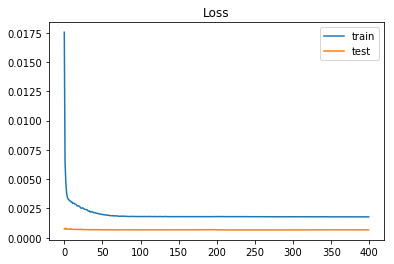

In [94]:
# plot loss function during training

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [95]:
print(dfresultados.loc[index_melhorserie])
print('\033[1m' +'Best MAPE Train:' + '\033[0m',"%.4f"%dfresultados.loc[index_melhorserie, 'MAPE Train'])
print('\033[1m' +'Best MAPE Test:' + '\033[0m',"%.4f"%dfresultados.loc[index_melhorserie, 'MAPE Test'])
print('\033[1m' +'Best RMSE Train:' + '\033[0m',"%.4f"%dfresultados.loc[index_melhorserie, 'RMSE Train'])
print('\033[1m' +'Best RMSE Test:' + '\033[0m',"%.4f"%dfresultados.loc[index_melhorserie, 'RMSE Test'])


   # of Neurons  Activation Function  Learning Rate Otmzador  Drop  \
0             44              linear           0.01     adam   0.3   

  Loss Function  MAPE Train  MAPE Test  RMSE Train  RMSE Test  
0           mse    7.135399   5.412169    0.042074   0.025908  
Best MAPE Train: 7.1354
Best MAPE Test: 5.4122
Best RMSE Train: 0.0421
Best RMSE Test: 0.0259


In [96]:
# saving the model 

import h5py
model1.save(filepath="lstmDif_stockindex_model.h5")
from keras.models import load_model
model1 = load_model(filepath="lstmDif_stockindex_model.h5")

yhattrain1 = model1.predict(train_X,batch_size=batch_size,verbose=0)
yhat1 = model1.predict(test_X,batch_size=batch_size,verbose=0)

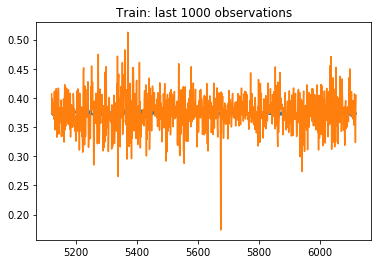

In [97]:
# getting the best model predictions
index_melhorserie=dfresultados.index[dfresultados['MAPE Test']==dfresultados['MAPE Test'].min()].tolist()
yhattrain1=dfresultados_ypredtrain.iloc[:,index_melhorserie]
yhat1=dfresultados_ypredtest.iloc[:,index_melhorserie]

trainy= pd.Series(train_y)
testy=pd.Series(test_y)

plt.title('Train: last 1000 observations')
plt.plot(yhattrain1[-1000:])
plt.plot(trainy[-1000:])

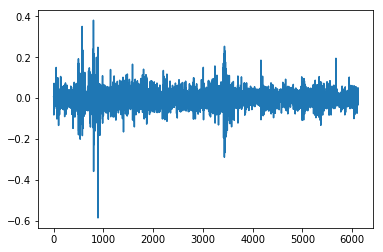

In [98]:
# Resids graph
res=(yhattrain1[0]-trainy)
plt.plot(res)

In [99]:
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -23.891832
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


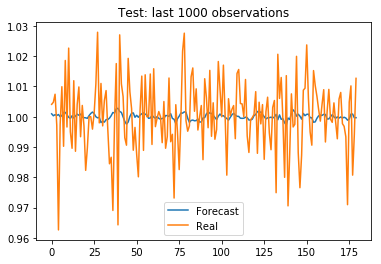

In [100]:
### Invert Scaling for test dataset
test_X1 = test_X.reshape((test_X.shape[0], timesteps*n_features))
# invert scaling for forecast
inv_yhat1 = np.concatenate((yhat1, test_X1[:, -(len(df.columns)-1):]), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]

nyhat1=np.exp(inv_yhat1)

# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y1 = np.concatenate((test_y1, test_X1[:, -(len(df.columns)-1):]), axis=1)
inv_y1 = scaler.inverse_transform(inv_y1)
inv_y1 = inv_y1[:,0]
nytest1=np.exp(inv_y1)

#test plot
plt.title('Test: last 1000 observations')
plt.plot(nyhat1[-1000:],label='Forecast')
plt.plot(nytest1[-1000:],label='Real')
plt.legend()
plt.show()

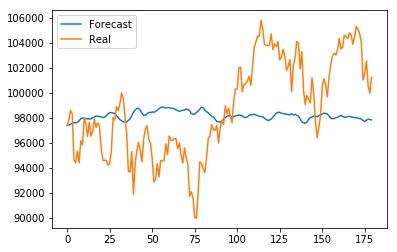

In [101]:
# invert to level LSTM
x=np.log(dfo.iloc[-len(inv_yhat1),0])
x_diff=pd.Series(inv_yhat1).iloc[1:,]
d=pd.Series(np.exp(pd.Series(np.r_[x, x_diff].cumsum())))
d
testsety=dfo.iloc[-len(inv_yhat1):,0]
testsety=testsety.reset_index(drop=True)
plt.plot(d,label='Forecast')
plt.plot(testsety,label='Real')
plt.legend()
plt.show()

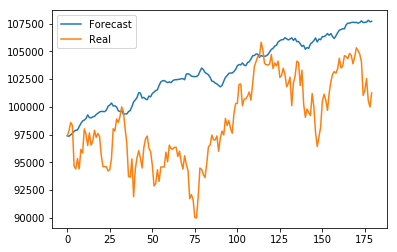

In [102]:
# invert to level OLS
x=np.log(dfo.iloc[-len(nyhatols),0])
x_diff=pd.Series(inv_yhatols).iloc[1:,]
dols=pd.Series(np.exp(pd.Series(np.r_[x, x_diff].cumsum())))
dols
testsety=dfo.iloc[-len(inv_yhat1):,0]
testsety=testsety.reset_index(drop=True)
plt.plot(dols,label='Forecast')
plt.plot(testsety,label='Real')
plt.legend()
plt.show()

In [103]:
# Mean Square Resids for LSTM
devlstm=(sum((testsety-d)**2)**0.5)/len(testsety)
devlstm

296.14921284863624

In [104]:
# Mean Square Resids for OLS
devlols=(sum((testsety-dols)**2)**0.5)/len(testsety)
devlols

390.1100830912445

In [105]:
print('Prediction LSTM in diff call for today',"%.2f"%d.iloc[-1:])
print('Prediction OLS in diff call for today',"%.2f"%dols.iloc[-1:])
print('Actual-Online',"%.2f"%dfo.iloc[-1,0:1])

Prediction LSTM in diff call for today 97836.27
Prediction OLS in diff call for today 107706.53
Actual-Online 101248.78
